# Fly Scans with EPICS motor and scaler

The `ScalerMotorFlyer()` device from [apstools](https://bcda-aps.github.io/apstools/api/_devices.html#apstools.devices.flyer_motor_scaler.ScalerMotorFlyer) makes it possible to run fly scans with just the EPICS motor and scaler records.

This combination of positioner and detector represent common EPICS support available to most APS beam lines.  An external fly scan controller is not necessary, nor is any dedicated data collection hardware.  Keep in mind that the capabilities of the motor and scaler will provide certain limits on how fast the scan completes and how many data points may be collected.

**Contents**

- [Step-by-step outline of 'ScalerMotorFlyer()'](#Outline)
- [Prepare the session](#Setup)
- [Run the fly scan](#Scan)
- [Get the data and plot it](#Visualize)

## Outline

Here is a step-by-step outline used by the `ScalerMotorFlyer()`:

1. Setup
   1. Motor velocity is set based on the requested `fly_time` for the scan.
   2. Scaler update rate is set from the requested sampling `period`.
2. Taxi
   1. Motor is moved to the `start` position.
   2. Scaler count time set to `fly_time` plus a smidgen.
   3. Wait for motor to reach `start` position.
3. Fly
   1. Scaler is started to count.
   2. Motor is sent to `finish`.
   3. Periodic data collection
      1. Scaler provides (EPICS Channel Access) updates as new data is available.
      2. Record motor position & scaler channel counts.
      3. Record time stamps for motor and scaler (probably different).
      4. Data accumulated to internal memory.
   4. Wait for motor to stop moving.
   5. Scaler is stopped.
4. Finish
   1. Reset to previous values
      1. motor velocity
      2. scaler update rate
   2. Report any acquired data to Bluesky RunEngine.
      1. Data for each counter is reported as the difference of successive readings.

If any exceptions are raised by steps 1-3 (such as cannot set a value, timeout, wrong type of parameter given, ...), skip directly to step 4.

## Setup

TODO

In [1]:
%matplotlib inline
from apstools.devices import ScalerMotorFlyer
from bluesky import RunEngine
from bluesky import plans as bp
from bluesky.callbacks.best_effort import BestEffortCallback
from matplotlib import pyplot as plt
from ophyd import EpicsMotor
from ophyd.scaler import ScalerCH
import databroker

IOC = "gp:"

# ophyd-level
m1 = EpicsMotor(f"{IOC}m10", name="motor")
scaler = ScalerCH(f"{IOC}scaler1", name="scaler")
m1.wait_for_connection()
scaler.wait_for_connection()
scaler.select_channels()

# bluesky-level
best_effort_callback = BestEffortCallback()
cat = databroker.temp().v2
plt.ion()  # enables matplotlib graphics
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(best_effort_callback)  # LivePlot & LiveTable

1

In [2]:
flyer = ScalerMotorFlyer(scaler, m1, 1, 5, fly_time=4, period=.2, name="flyer")

## Scan

TODO

In [3]:
uids = RE(bp.fly([flyer], md=dict(purpose="Demonstrate a scaler v. motor fly scan.")))



Transient Scan ID: 1     Time: 2022-10-18 17:25:56
Persistent Unique Scan ID: 'd7a19fb8-c3cf-4b6f-8ea3-6727106f3851'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+


/home/prjemian/.conda/envs/bluesky_2022_3/lib/python3.9/site-packages/event_model/__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


+-----------+------------+
generator fly ['d7a19fb8'] (scan num: 1)





## Visualize

TODO

In [4]:
run = cat.v2[uids[0]]
run

BlueskyRun
  uid='d7a19fb8-c3cf-4b6f-8ea3-6727106f3851'
  exit_status='success'
  2022-10-18 17:25:56.558 -- 2022-10-18 17:26:05.193
  Streams:
    * primary


In [5]:
print(f"{run.metadata['start']['scan_id']=}")
print(f"{run.metadata['start']['purpose']=}")

run.metadata['start']['scan_id']=1
run.metadata['start']['purpose']='Demonstrate a scaler v. motor fly scan.'


In [6]:
dataset = run.primary.read()
dataset

<xarray.Dataset>
Dimensions:              (time: 22)
Coordinates:
  * time                 (time) float64 1.666e+09 1.666e+09 ... 1.666e+09
Data variables:
    motor                (time) float64 1.0 1.09 1.29 1.49 ... 4.4 4.6 4.8 4.97
    motor_user_setpoint  (time) float64 1.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    timebase             (time) float64 -1e+06 1e+06 2e+06 ... 2e+06 2e+06 2e+06
    I0                   (time) float64 0.0 0.0 1.0 2.0 0.0 ... 1.0 1.0 1.0 1.0
    scint                (time) float64 0.0 0.0 1.0 1.0 1.0 ... 1.0 0.0 1.0 1.0
    diode                (time) float64 0.0 0.0 0.0 2.0 1.0 ... 2.0 0.0 2.0 2.0
    I000                 (time) float64 0.0 0.0 1.0 1.0 1.0 ... 2.0 0.0 0.0 1.0
    I00                  (time) float64 0.0 0.0 1.0 2.0 1.0 ... 1.0 1.0 0.0 2.0
    scaler_time          (time) float64 -0.1 0.1 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2

In [7]:
x = dataset["motor"]
y = dataset["diode"]

Text(0, 0.5, 'diode')

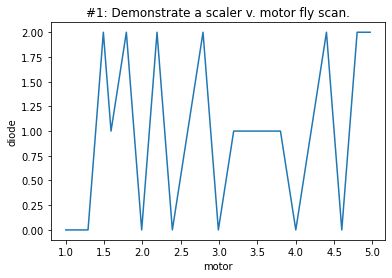

In [8]:
title = (
    f"#{run.metadata['start']['scan_id']}"
    f": {run.metadata['start']['purpose']}"
)
plt.plot(x.values, y.values)
plt.title(title)
plt.xlabel(x.name)
plt.ylabel(y.name)